## Pinball Loss

The pinball loss is defined as:

$$ 
\text{Pinball}(y, \hat{y}, \alpha) = \frac{1}{n} \sum_{i=1}^{n} \alpha \cdot \max(0, y_i - \hat{y}_i) + (1 - \alpha) \cdot \max(0, \hat{y}_i - y_i)
$$  

where:

- $y$ is the true target value

- $\hat{y}$ is the predicted (point estimate) value

- $\alpha$ is the **risk** level (0 < $\alpha$ < 1); $1 - \alpha$ is the **confidence** level

- $n$ is the number of samples

- $\max(0, y_i - \hat{y}_i)$ is the positive part of the error when the true value is greater than the predicted value

- $\max(0, \hat{y}_i - y_i)$ is the positive part of the error when the predicted value is greater than the true value

The pinball loss is particularly useful in quantile regression, where the goal is to estimate the conditional quantiles of a response variable. By adjusting the $\alpha$ parameter, one can focus on different parts of the distribution of the target variable.

In [1]:
from typing import Iterable, Tuple

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_pinball_loss

In [2]:
def plot_synthetic_pinball_curve(
    residual_grid: np.ndarray,
    alphas: Iterable[float] = (0.1, 0.5, 0.9),
) -> None:
    """
    Plot theoretical pinball loss vs residual for specified quantiles.

    Parameters
    ----------
    residual_grid : np.ndarray
        Grid of residuals r = y - y_hat over which to compute loss.
    alphas : Iterable[float], default=(0.1, 0.5, 0.9)
        Quantile levels to plot.
    """
    plt.figure()
    for alpha in alphas:
        # Loss for residual r given alpha
        loss_vals = np.where(
            residual_grid >= 0, alpha * residual_grid, (1 - alpha) * (-residual_grid)
        )
        plt.plot(residual_grid, loss_vals, label=f"alpha = {alpha}")

    # Shade regions: residual > 0 means underprediction, residual < 0 means overprediction
    plt.axvline(0, color="black", linewidth=1)
    plt.fill_between(
        residual_grid,
        0,
        np.max(loss_vals),
        where=(residual_grid > 0),
        alpha=0.1,
        label="Underprediction (y > ŷ)",
    )
    plt.fill_between(
        residual_grid,
        0,
        np.max(loss_vals),
        where=(residual_grid < 0),
        alpha=0.1,
        label="Overprediction (y < ŷ)",
    )
    plt.xlabel("Residual r = y - ŷ")
    plt.ylabel("Pinball loss")
    plt.title("Pinball loss vs residual (theoretical) with shading")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.0)
    plt.show()

In [3]:
def simulate_linear_dgp(
    n: int,
    rng: np.random.Generator,
    beta: Tuple[float, float] = (0.0, 2.0),
    noise_sd: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate a simple linear data generating process (DGP): y = beta_0 + beta_1 * x + eps.

    Parameters
    ----------
    n : int
        Sample size.
    rng : np.random.Generator
        Random number generator.
    beta : Tuple[float, float], default=(0.0, 2.0)
        Intercept and slope.
    noise_sd : float, default=1.0
        Standard deviation of Gaussian noise.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Feature matrix X with shape (n, 1) and response y with shape (n,).
    """
    x = rng.normal(size=n)
    eps = rng.normal(scale=noise_sd, size=n)
    y = beta[0] + beta[1] * x + eps
    X = x.reshape(-1, 1)
    return X, y

In [4]:
def plot_empirical_trained_model_curve(
    n_train: int = 4000,
    n_test: int = 4000,
    alphas: Iterable[float] = (0.1, 0.5, 0.9),
    shift_grid: np.ndarray | None = None,
    seed: int = 12,
) -> None:
    """Train quantile regressors and plot empirical mean pinball loss vs residual shift.

    Parameters
    ----------
    n_train : int, default=4000
        Training sample size.
    n_test : int, default=4000
        Test sample size.
    alphas : Iterable[float], default=(0.1, 0.5, 0.9)
        Quantile levels to fit and evaluate.
    shift_grid : np.ndarray | None, default=None
        Grid of additive shifts applied to predictions. If None a default grid is used.
    seed : int, default=123
        Random seed for reproducibility.
    """
    rng = np.random.default_rng(seed)
    X_train, y_train = simulate_linear_dgp(n_train, rng)
    X_test, y_test = simulate_linear_dgp(n_test, rng)

    models = {
        alpha: QuantileRegressor(quantile=alpha, alpha=1e-4, solver="highs").fit(
            X_train, y_train
        )
        for alpha in alphas
    }

    if shift_grid is None:
        shift_grid = np.linspace(-3, 3, 121)

    plt.figure()
    max_loss = 0
    for alpha, model in models.items():
        yhat = model.predict(X_test)
        yhat_matrix = yhat[None, :] + shift_grid[:, None]
        losses = [
            mean_pinball_loss(y_test, yhat_row, alpha=alpha) for yhat_row in yhat_matrix
        ]
        plt.plot(shift_grid, losses, label=f"alpha = {alpha}")
        max_loss = max(max_loss, max(losses))

    # Shade regions: positive shift = overprediction, negative shift = underprediction
    plt.axvline(0, color="black", linewidth=1)
    plt.fill_between(
        shift_grid,
        0,
        max_loss,
        where=(shift_grid > 0),
        alpha=0.1,
        label="Overprediction (ŷ > y)",
    )
    plt.fill_between(
        shift_grid,
        0,
        max_loss,
        where=(shift_grid < 0),
        alpha=0.1,
        label="Underprediction (ŷ < y)",
    )

    plt.xlabel("Residual shift added to predictions")
    plt.ylabel("Empirical mean pinball loss")
    plt.title("Pinball loss vs residual shift (trained models) with shading")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.0)
    plt.show()

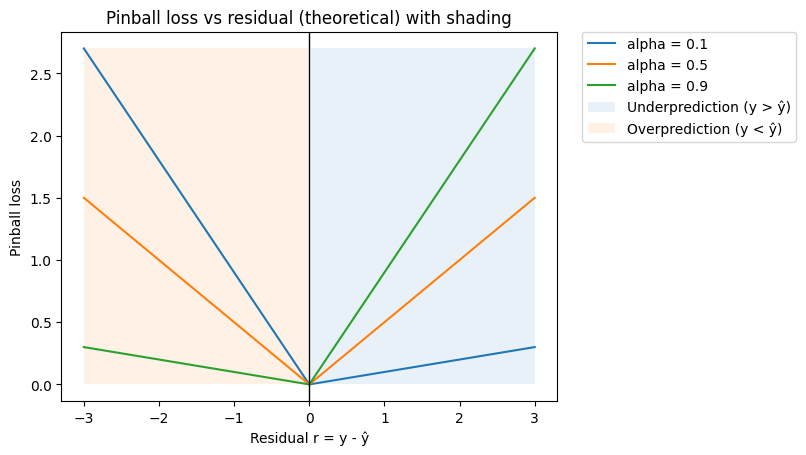

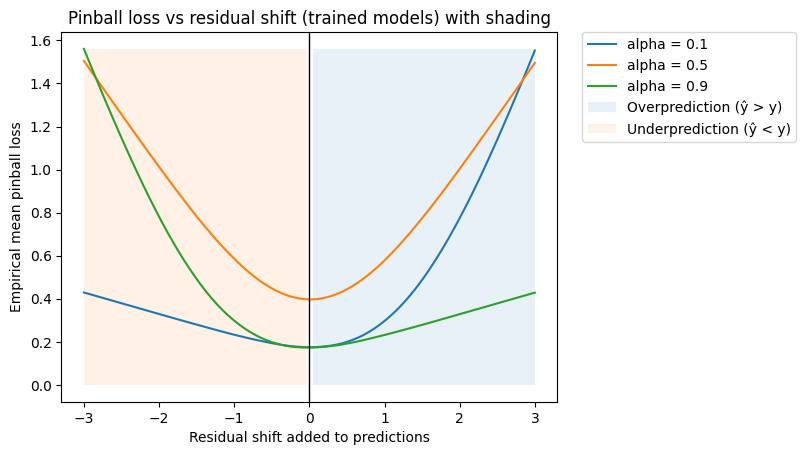

In [5]:
res_grid = np.linspace(-3, 3, 301)
plot_synthetic_pinball_curve(res_grid, alphas=(0.1, 0.5, 0.9))
plot_empirical_trained_model_curve(
    n_train=4000, n_test=4000, alphas=(0.1, 0.5, 0.9), seed=1227
)